In [39]:
import meshio
import torch

import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.nn as pyg_nn
from torch_geometric.utils import to_networkx
from torch_geometric.utils import add_self_loops, degree

import numpy as np
import matplotlib.pyplot as plt

from torch_geometric.data import Data

import networkx as nx

In [41]:
print(torch.cuda.is_available())  # Should return True
print(torch.cuda.current_device())  # Should return an integer (GPU index)
print(torch.cuda.get_device_name(torch.cuda.current_device()))  # GPU name

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

print(f"Using device: {device}")

torch.backends.cudnn.benchmark = True

True
0
NVIDIA GeForce GTX 1650
Using device: cuda


In [17]:
mesh = meshio.read("meshes/plate_hole.msh")
print(mesh)


<meshio mesh object>
  Number of points: 467
  Number of cells:
    vertex: 5
    line: 85
    triangle: 849
  Cell data: gmsh:physical, gmsh:geometrical


In [45]:
nodes = torch.tensor(mesh.points, dtype=torch.float)
nodes_2d = nodes[:, :2]
elements = mesh.cells_dict


faces = elements["triangle"]  # (num_faces, 3)
edges = np.vstack([faces[:, [0, 1]], faces[:, [1, 2]], faces[:, [2, 0]]])  # Convert triangles to edges

edges = torch.tensor(np.unique(edges, axis=0).T, dtype=torch.long)  # Shape: (2, num_edges)

graph_data = Data(x=nodes_2d, edge_index=edges).to(device)

edge_attr = torch.norm(nodes_2d[edges[0]] - nodes_2d[edges[1]], dim=1, keepdim=True)  # Compute Euclidean distance
graph_data.edge_attr = edge_attr
graph_data.x.requires_grad = True


print(graph_data)


Data(x=[467, 2], edge_index=[2, 2547], edge_attr=[2547, 1])


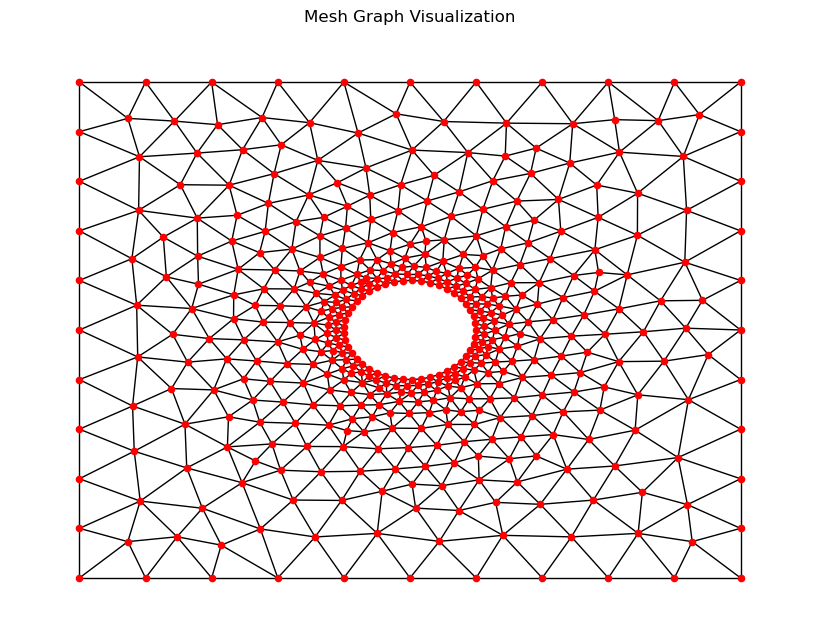

In [26]:


# Assuming you already have the Data object (graph_data)
nodes = graph_data.x.numpy()  # Extract node positions (Numpy array)
edges = graph_data.edge_index.numpy()  # Edge list in (2, num_edges)

# Create a NetworkX graph
G = nx.Graph()

# Add nodes with their positions
for i, node in enumerate(nodes):
    G.add_node(i, pos=node)

# Add edges based on edge_index
for i in range(edges.shape[1]):
    G.add_edge(edges[0, i], edges[1, i])

# Get positions for plotting
pos = nx.get_node_attributes(G, 'pos')

# Draw the graph
plt.figure(figsize=(8, 6))
nx.draw(G, pos, with_labels=False, node_size=20, node_color='red', font_size=10, width=1, edge_color='black')
plt.title("Mesh Graph Visualization")
plt.show()


In [63]:
pos = graph_data.x

y = pos[:,0:1]*10 + pos[:, 1:2]*5

dy = torch.autograd.grad(y, pos, torch.ones_like(y), create_graph=True)[0][:,1:2]
print(dy)

tensor([[5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
      

In [49]:
coord = graph_data.x
x = coord[:, 0:1]
y = coord[:, 1:2]

zero = torch.zeros_like(x)
ones = torch.ones_like(x)

mask_left = torch.eq(x, zero)
mask_right = torch.eq(x, ones)
mask_top = torch.eq(y, ones)
mask_bot = torch.eq(y, zero)

rad = torch.sqrt((x - 1/2)**2 + (y - 1/2)**2)
r = torch.ones_like(x) * 0.1
mask_hole = torch.isclose(rad, r)

masks = {'left': mask_left, 'top': mask_top, 'right': mask_right, 'bot': mask_bot, 'hole': mask_hole}

In [ ]:
class MPGNN(pyg_nn.MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr="mean")
        self.linear = nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        return self.propagate(edge_index, x=x)
    
    def message(self, x_j):
        return self.linear(x_j)
    
    def update(self, aggr_out):
        return F.tanh(aggr_out)
    

class GNN(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.conv1 = MPGNN(in_dim, hidden_dim)
        self.conv2 = MPGNN(hidden_dim, hidden_dim)
        self.conv3 = MPGNN(hidden_dim, hidden_dim)
        self.conv4 = MPGNN(hidden_dim, out_dim)


    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.conv2(x, edge_index)
        x = self.conv3(x, edge_index)
        x = self.conv4(x, edge_index)
        return x

In [64]:
class PINN():
    def __init__(self, graph, masks, r, nu):

        self.graph = graph

        self.mask_left = masks['left']
        self.mask_top = masks['top']
        self.mask_right = masks['right']
        self.mask_bot = masks['bot']
        self.mask_hole = masks['hole']

        self.nu = nu

        self.r = r

        self.in_dim = 2
        self.hid_dim = 128
        self.out_dim = 5

        # DNN
        self.gnn = GNN(self.in_dim, self.hid_dim, self.out_dim).to(device)

        # Optimizer
        self.optimizer_lbfgs = torch.optim.LBFGS(
            self.gnn.parameters(),
            lr=0.01,
            max_iter=5000,
            max_eval=5000,
            history_size=200,
            tolerance_grad=1e-20,
            tolerance_change=1e-20,
        )

        self.optimizer_adam = torch.optim.Adam(self.gnn.parameters(), lr=0.01)
        # self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer_adam, step_size=2000, gamma=0.5)
        self.iter = 0

    def model_value(self, graph):
        out = self.gnn(graph)
        u = out[:,0:1]
        v = out[:,1:2]
        sxx = out[:,2:3]
        syy = out[:,3:4]
        sxy = out[:,4:5]
        return u, v, sxx, syy, sxy

    def pde_loss(self, graph):
        pos = graph.x
        u, v, sxx, syy, sxy = self.model_value(graph)

        dx_u = torch.autograd.grad(u, pos, torch.ones_like(u), create_graph=True)[0][:,0:1]
        dy_u = torch.autograd.grad(u, pos, torch.ones_like(u), create_graph=True)[0][:,1:2]
        dx_v = torch.autograd.grad(v, pos, torch.ones_like(v), create_graph=True)[0][:,0:1]
        dy_v = torch.autograd.grad(v, pos, torch.ones_like(v), create_graph=True)[0][:,1:2]

        dx_sxx = torch.autograd.grad(sxx, pos, torch.ones_like(sxx), create_graph=True)[0][:,0:1]
        dy_syy = torch.autograd.grad(syy, pos, torch.ones_like(syy), create_graph=True)[0][:,1:2]
        dy_sxy = torch.autograd.grad(sxy, pos, torch.ones_like(sxy), create_graph=True)[0][:,1:2]
        dx_sxy = torch.autograd.grad(sxy, pos, torch.ones_like(sxy), create_graph=True)[0][:,0:1]

        term_xx = 1 / (1 - self.nu**2) * (dx_u + self.nu*dy_v)
        term_yy = 1 / (1 - self.nu**2) * (dy_v + self.nu*dx_u)
        term_xy = 1 / (2*(1 + self.nu)) * (dy_u + dx_v)

        r1 = torch.mean(torch.pow((sxx - term_xx), 2))
        r2 = torch.mean(torch.pow((syy - term_yy), 2))
        r3 = torch.mean(torch.pow((sxy - term_xy), 2))
        r4 = torch.mean(torch.pow((dx_sxx + dy_sxy), 2))
        r5 = torch.mean(torch.pow((dy_syy + dx_sxy), 2))

        residual = r1 + r2+ r3 + r4 + r5
        return residual

    def bc_loss(self, graph):
        coord = graph.x
        x = coord[:, 0:1]
        y = coord[:, 1:2]
        u, v, sxx, syy, sxy = self.model_value(graph)

        b = torch.mean(torch.pow(u[self.mask_left], 2))
        b += torch.mean(torch.pow(v[self.mask_left], 2))

        b += torch.mean(torch.pow(syy[self.mask_top], 2))
        b += torch.mean(torch.pow(sxy[self.mask_top], 2))

        b += torch.mean(torch.pow(sxx[self.mask_right] - 1, 2))
        b += torch.mean(torch.pow(sxy[self.mask_right], 2))

        b += torch.mean(torch.pow(syy[self.mask_bot], 2))
        b += torch.mean(torch.pow(sxy[self.mask_bot], 2))


        nx = -(x[self.mask_hole] - 1/2) / self.r
        ny = -(y[self.mask_hole] - 1/2) / self.r
        tx = torch.mul(sxx[self.mask_hole], nx) + torch.mul(sxy[self.mask_hole], ny)
        ty = torch.mul(sxy[self.mask_hole], nx) + torch.mul(syy[self.mask_hole], ny)

        b += torch.mean(torch.pow(tx, 2))
        b += torch.mean(torch.pow(ty, 2))

        return b

    
    def loss_func(self):
        pde = self.pde_loss(self.graph)
        bc = self.bc_loss(self.graph)
        return pde, bc


    def lbfgs_func(self):
        pde_loss, bc_loss = self.loss_func()
        loss = pde_loss + bc_loss
        self.optimizer_lbfgs.zero_grad()
        loss.backward()

        if self.iter % 100 == 0:
            print(f"Iter: {self.iter}, Loss: {'{:e}'.format(loss.item())}")
        self.iter += 1
        return loss
    
    def train(self, epochs=1000):
        self.gnn.train()
        for epoch in range(epochs):
            pde_loss, bc_loss = self.loss_func()
            loss = pde_loss + bc_loss

            self.optimizer_adam.zero_grad()
            loss.backward()
            self.optimizer_adam.step()
            # self.scheduler.step()

            if epoch % 100 == 0:
                print(f"Epoch {epoch}, Loss: {'{:e}'.format(loss.item())}")
                print(f"PDE: {'{:e}'.format(pde_loss.item())}, BC: {'{:e}'.format(bc_loss.item())}")
        self.optimizer_lbfgs.step(self.lbfgs_func)

In [65]:
model = PINN(graph_data, masks, 0.1, 0.3)

In [66]:
model.train(5000)

Epoch 0, Loss: 9.696401e-01
PDE: 3.668914e-02, BC: 9.329509e-01
Epoch 100, Loss: 2.672350e-01
PDE: 3.563528e-02, BC: 2.315997e-01
Epoch 200, Loss: 1.526566e-01
PDE: 5.566388e-02, BC: 9.699275e-02
Epoch 300, Loss: 1.144879e-01
PDE: 5.404367e-02, BC: 6.044423e-02
Epoch 400, Loss: 1.459574e-01
PDE: 1.013664e-01, BC: 4.459101e-02
Epoch 500, Loss: 1.015895e-01
PDE: 5.581975e-02, BC: 4.576978e-02
Epoch 600, Loss: 9.495336e-02
PDE: 5.725236e-02, BC: 3.770100e-02
Epoch 700, Loss: 9.113054e-02
PDE: 5.929117e-02, BC: 3.183936e-02
Epoch 800, Loss: 9.184557e-02
PDE: 5.910714e-02, BC: 3.273843e-02
Epoch 900, Loss: 8.235984e-02
PDE: 5.897016e-02, BC: 2.338967e-02
Epoch 1000, Loss: 8.009866e-02
PDE: 5.730000e-02, BC: 2.279866e-02
Epoch 1100, Loss: 7.647155e-02
PDE: 5.890146e-02, BC: 1.757009e-02
Epoch 1200, Loss: 7.715279e-02
PDE: 5.120520e-02, BC: 2.594759e-02
Epoch 1300, Loss: 6.128637e-02
PDE: 4.501645e-02, BC: 1.626992e-02
Epoch 1400, Loss: 5.956916e-02
PDE: 4.528213e-02, BC: 1.428702e-02
Epoch 1

KeyboardInterrupt: 

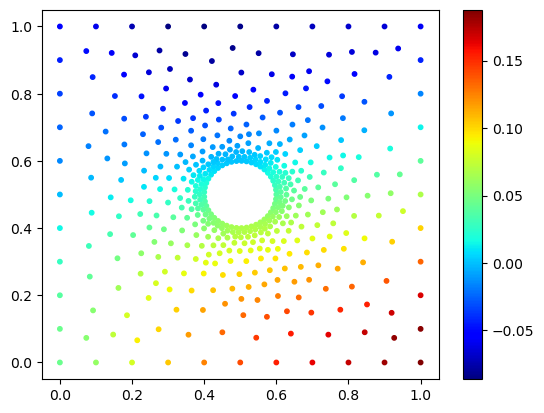

In [73]:
u, v, sxx, syy, sxy = model.model_value(graph_data)

coord = graph_data.x
x = coord[:, 0:1]
y = coord[:, 1:2]

x_pred = x.detach().cpu().numpy()
y_pred = y.detach().cpu().numpy()
u_pred = v.detach().cpu().numpy()

sc = plt.scatter(x_pred, y_pred, c=u_pred, cmap='jet', s=10)
plt.colorbar(sc)

